In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("../")

In [3]:
import ast
import yaml
import json
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

from typing import Tuple
from util import count_edge_crossings

# Analysis of `transpose_prompts_median`

## Constants and helpers

In [4]:
# Some constants
WRONG_FORMAT = -1
MISSING_NODES = -2
EXTRA_NODES = -3
WRONG_RANKS = -4

In [5]:
def read_rank_response(answer: str) -> dict:
    answer = answer.split("\n")
    answer_ranks = {}
    for line in answer:
        if line == "":
            continue
        rank = int(line.split("Layer ")[1].split(":")[0].strip())
        nodes = ast.literal_eval(line.split(":")[1].strip())
        answer_ranks[rank] = nodes

    return answer_ranks


def check_nodes(answers: dict, queries: dict) -> Tuple[dict, dict, dict, dict]:
    all_nodes_queries = {}
    for query_file, query_dict in queries.items():
        all_nodes_queries[query_file] = set()
        for edge in query_dict["edges"]:
            all_nodes_queries[query_file].add(edge[0])
            all_nodes_queries[query_file].add(edge[1])

    # Print the number of nodes in the graphs of each query
    all_nodes_orig_number = [
        len(all_nodes_queries[query_file]) for query_file in all_nodes_queries
    ]
    print("\nUnique number of nodes in the graphs of each query:")
    print(np.unique(all_nodes_orig_number, return_counts=True))

    all_nodes_answers = {}
    for answer_file, answer_dict in answers.items():
        all_nodes_answers[answer_file] = set()
        for rank, nodes in answer_dict.items():
            for node in nodes:
                all_nodes_answers[answer_file].add(node)

    # Print the number of nodes in the graphs of each answer
    all_nodes_answer_number = [
        len(all_nodes_answers[answer_file]) for answer_file in all_nodes_answers
    ]
    print("\nUnique number of nodes in the graphs of each answer:")
    print(np.unique(all_nodes_answer_number, return_counts=True))

    correct_nodes_answers = {}
    incorrect_nodes_answers = {}
    for answer_file, answer_dict in answers.items():
        answer_nodes = all_nodes_answers[answer_file]
        query_nodes = all_nodes_queries[answer_file]

        if answer_nodes == query_nodes:
            correct_nodes_answers[answer_file] = answer_dict
        else:
            incorrect_nodes_answers[answer_file] = answer_dict

    print("\nCorrect nodes answers: ", len(correct_nodes_answers))
    print("Incorrect nodes answers: ", len(incorrect_nodes_answers))

    increased_nodes_answers = {}
    decreased_nodes_answers = {}

    for answer_file, answer_dict in incorrect_nodes_answers.items():
        answer_nodes = all_nodes_answers[answer_file]
        query_nodes = all_nodes_queries[answer_file]

        if len(answer_nodes) > len(query_nodes):
            increased_nodes_answers[answer_file] = answer_dict
        else:
            decreased_nodes_answers[answer_file] = answer_dict

    print("\nIncreased nodes answers: ", len(increased_nodes_answers))
    print("Decreased nodes answers: ", len(decreased_nodes_answers))

    return (
        correct_nodes_answers,
        incorrect_nodes_answers,
        increased_nodes_answers,
        decreased_nodes_answers,
    )


def check_ranks(answers: dict, queries: dict) -> Tuple[dict, dict]:
    # Check if all the answers have a correct rank assignment
    correct_rank_answers = {}
    incorrect_rank_answers = {}

    for answer_file, answer_dict in answers.items():
        query_ranks = queries[answer_file]["ranks"]
        for rank, nodes in answer_dict.items():
            if rank not in query_ranks:
                incorrect_rank_answers[answer_file] = answer_dict
                break

            query_nodes_at_rank = query_ranks[rank]
            for node in nodes:
                if node not in query_nodes_at_rank:
                    incorrect_rank_answers[answer_file] = answer_dict
                    break

        if answer_file not in incorrect_rank_answers:
            correct_rank_answers[answer_file] = answer_dict

    print("Number of correct rank answers:", len(correct_rank_answers))
    print("Number of incorrect rank answers:", len(incorrect_rank_answers))

    return correct_rank_answers, incorrect_rank_answers


def visualize_graph(ranks: dict, edges: list, filter_same_rank: False):
    plt.figure(figsize=(14, 5))

    edges_out_of_node = {}
    for edge in edges:
        if edge[0] not in edges_out_of_node:
            edges_out_of_node[edge[0]] = []
        edges_out_of_node[edge[0]].append(edge[1])
        if edge[1] not in edges_out_of_node:
            edges_out_of_node[edge[1]] = []
        edges_out_of_node[edge[1]].append(edge[0])

    G = nx.Graph()
    for layer_n, layer in ranks.items():
        for node in layer:
            G.add_node(node, layer=layer_n)

    pos = nx.multipartite_layout(G, subset_key="layer")
    nodes_draw = nx.draw_networkx_nodes(G, pos)
    node_labels_dict = nx.draw_networkx_labels(
        G,
        pos,
        font_color="white",
        font_weight="bold",
    )

    for layer_n, layer in ranks.items():
        for node in layer:
            if node in edges_out_of_node:
                for edge_target in edges_out_of_node[node]:
                    if filter_same_rank and edge_target in layer:
                        continue
                    G.add_edge(node, edge_target)
    edges_draw = nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)

    plt.show()


def visualize_results(results: dict, color="skyblue"):
    # Generate some sample data as a dictionary
    data = {}

    # Count the number of entries for which new_crossings is positive and new_crossings < original_crossings
    improved_answers = list(
        filter(
            lambda x: x["new_crossings"] >= 0
            and x["new_crossings"] < x["original_crossings"],
            results,
        )
    )
    data["Improved\nanswers"] = len(improved_answers)

    # Count the number of entries for which new_crossings is positive and new_crossings == original_crossings
    equivalent_answers = list(
        filter(
            lambda x: x["new_crossings"] >= 0
            and x["new_crossings"] == x["original_crossings"],
            results,
        )
    )
    data["Equivalent\nanswers"] = len(equivalent_answers)

    # Count the number of entries for which new_crossings is positive and new_crossings > original_crossings
    worsened_answers = list(
        filter(
            lambda x: x["new_crossings"] >= 0
            and x["new_crossings"] > x["original_crossings"],
            results,
        )
    )
    data["Worsened\nanswers"] = len(worsened_answers)

    # Count the number of changed ranks
    changed_ranks = list(
        filter(lambda x: x["new_crossings"] == WRONG_RANKS, results)
    )
    data["Changed\nranks"] = len(changed_ranks)

    # Count the number of malformed answers
    malformed_answers = list(
        filter(lambda x: x["new_crossings"] == WRONG_FORMAT, results)
    )
    data["Malformed\nanswers"] = len(malformed_answers)

    # Count the number of answers with missing nodes
    missing_nodes = list(
        filter(lambda x: x["new_crossings"] == MISSING_NODES, results)
    )
    data["Missing\nnodes"] = len(missing_nodes)

    # Count the number of answers with extra nodes
    extra_nodes = list(filter(lambda x: x["new_crossings"] == EXTRA_NODES, results))
    data["Extra\nnodes"] = len(extra_nodes)

    df = pd.DataFrame.from_dict(data, orient="index", columns=["Value"])
    sns.set(rc={"figure.figsize": (15, 3)})
    sns.barplot(x=df.index, y="Value", data=df, color=color)
    plt.ylabel("Count")
    plt.show()

    return data, df, improved_answers, worsened_answers, equivalent_answers


## Read all queries

In [6]:
def read_transpose_median_query(query:str) -> Tuple[list, dict]:
    query_edges = ast.literal_eval(query.split("\n")[1].strip())

    query_ranks_str = query.split("This is the description of what nodes are contained in what layer:")[1]
    query_ranks_str = query_ranks_str.split("Write no code and no explanations.")[0].strip()
    query_ranks_str = query_ranks_str.split("\n") 
    query_ranks = {}
    for line in query_ranks_str:
        rank = int(line.split("Layer ")[1].split(":")[0].strip())
        nodes = ast.literal_eval(line.split(":")[1].strip())
        query_ranks[rank] = nodes
    
    return query_edges, query_ranks

In [7]:
std_query_dir = "queries/transpose_prompts_no_steps_median"
step_query_dir = "queries/transpose_prompts_steps_median"
icl_query_dir = "queries/transpose_prompts_icl_median"

std_query_files = sorted(os.listdir(std_query_dir))
step_query_files = sorted(os.listdir(step_query_dir))
icl_query_files = sorted(os.listdir(icl_query_dir))

print("Standard queries:", len(std_query_files))
print("Step queries:", len(step_query_files))
print("ICL queries:", len(icl_query_files))

# Check that all the query files are the same
assert set(std_query_files) == set(step_query_files) == set(icl_query_files)

Standard queries: 50
Step queries: 50
ICL queries: 50


In [8]:
queries = {}

for query_file in std_query_files:
    query = open(os.path.join(std_query_dir, query_file)).read().strip()

    query_edges, query_ranks = read_transpose_median_query(query)
    
    queries[query_file] = {"edges": query_edges, "ranks": query_ranks}

print("Number of queries read: ", len(queries))

Number of queries read:  50


## Results for Standard queries

In [9]:
std_answer_dir = "answers/transpose_prompts_no_steps_median"
std_answer_files = sorted(os.listdir(std_answer_dir))
print("Standard answers:", len(std_answer_files))

Standard answers: 50


In [10]:
std_answers = {}
std_answers_malformed = {}

for std_answer_file in std_answer_files:
    with open(os.path.join(std_answer_dir, std_answer_file)) as f:
        answer = f.read()
    
    try:
        answer_ranks = read_rank_response(answer)
        std_answers[std_answer_file] = answer_ranks
    except Exception as e:
        std_answers_malformed[std_answer_file] = answer


print("Standard answers:", len(std_answers))
print("Standard malformed answers:", len(std_answers_malformed))
print(std_answers_malformed.keys())

Standard answers: 47
Standard malformed answers: 3
dict_keys(['grafo1137.10.txt', 'grafo462.10.txt', 'grafo898.10.txt'])


In [11]:
# We manually analyze the malformed answers
std_additional = {}
std_additional["grafo1137.10.txt"] = read_rank_response("""Layer 0: [0]
Layer 1: [5, 3]
Layer 2: [9, 7, 8]
Layer 3: [6, 1, 2, 4]""")
std_additional["grafo462.10.txt"] = read_rank_response("""Layer 0: [0]
Layer 1: [6, 7, 8]
Layer 2: [2, 1, 5, 3]
Layer 3: [9]
Layer 4: [4]""")
std_additional["grafo898.10.txt"] = read_rank_response("""Layer 0: [0]
Layer 1: [6]
Layer 2: [1]
Layer 3: [7]
Layer 4: [2, 3]
Layer 5: [8, 9]
Layer 6: [5, 4]""")

for k in std_additional.keys():
    std_answers[k] = std_additional[k]
    _ = std_answers_malformed.pop(k)

print("Standard answers:", len(std_answers))
print("Standard malformed answers:", len(std_answers_malformed))

Standard answers: 50
Standard malformed answers: 0


In [12]:
(
    correct_nodes_answers_std,
    incorrect_nodes_answers_std,
    increased_nodes_answers_std,
    decreased_nodes_answers_std,
) = check_nodes(std_answers, queries)

correct_rank_answers_std, incorrect_rank_answers_std = check_ranks(correct_nodes_answers_std, queries)

results_std = []
for i, query in enumerate(queries):

    c = count_edge_crossings(queries[query]["edges"], queries[query]["ranks"])
    if query in correct_rank_answers_std:
        c2 = count_edge_crossings(queries[query]["edges"], std_answers[query])
    elif query in incorrect_rank_answers_std:
        c2 = WRONG_RANKS
    elif query in increased_nodes_answers_std:
        c2 = EXTRA_NODES
    elif query in decreased_nodes_answers_std:
        c2 = MISSING_NODES
    else:
        c2 = WRONG_FORMAT
    # print("original crossings: ", c, "new crossings: ", c2)
    results_std.append({
        "query": query,
        "original_crossings": c,
        "new_crossings": c2,
    })



Unique number of nodes in the graphs of each query:
(array([10, 11]), array([16, 34]))

Unique number of nodes in the graphs of each answer:
(array([10, 11]), array([16, 34]))

Correct nodes answers:  50
Incorrect nodes answers:  0

Increased nodes answers:  0
Decreased nodes answers:  0
Number of correct rank answers: 45
Number of incorrect rank answers: 5


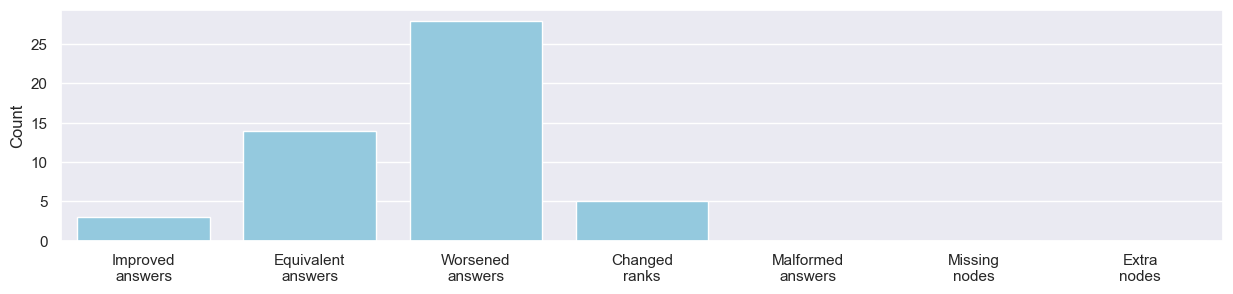

In [13]:
data_std, df_std, improved_answers_std, worsened_answers_std, equivalent_answers_std = visualize_results(results_std)

## Results for Step queries

In [14]:
step_answer_dir = "answers/transpose_prompts_steps_median"
step_answer_files = sorted(os.listdir(step_answer_dir))
print("step answers:", len(step_answer_files))

step answers: 50


In [15]:
# These answers are formatted in generally different ways, so we 
# will approach them differently
step_answers = {}
step_answers_malformed = {}

for step_answer_file in step_answer_files:
    with open(os.path.join(step_answer_dir, step_answer_file)) as f:
        answer = f.read()
    
    if "Layer 0:" not in answer:
        step_answers_malformed[step_answer_file] = answer
        continue

    answer = answer.split("Layer 0:")[-1].strip() # Take only the last answer
    answer = "Layer 0:" + answer

    try:
        answer_ranks = read_rank_response(answer)
        step_answers[step_answer_file] = answer_ranks
    except Exception as e:
        step_answers_malformed[step_answer_file] = answer

print("step answers:", len(step_answers))
print("step malformed answers:", len(step_answers_malformed))
print(step_answers_malformed.keys())

step answers: 47
step malformed answers: 3
dict_keys(['grafo2931.11.txt', 'grafo532.11.txt', 'grafo938.10.txt'])


In [16]:
step_additional = {}
step_additional["grafo2931.11.txt"] = read_rank_response("""Layer 0: [0]
Layer 1: [6]
Layer 2: [1, 10]
Layer 3: [7, 2, 5, 4, 3]
Layer 4: [9, 8]""")
step_additional["grafo532.11.txt"] = read_rank_response("""Layer 0: [0]
Layer 1: [7, 10, 6]
Layer 2: [1, 2, 9, 4]
Layer 3: [5, 8]
Layer 4: [3]""")
step_additional["grafo938.10.txt"] = read_rank_response("""Layer 0: [0]
Layer 1: [9]
Layer 2: [2, 3, 6, 7, 8]
Layer 3: [1, 5]
Layer 4: [4]""")

for k in step_additional.keys():
    step_answers[k] = step_additional[k]
    _ = step_answers_malformed.pop(k)

print("step answers:", len(step_answers))
print("step malformed answers:", len(step_answers_malformed))

step answers: 50
step malformed answers: 0


In [17]:
(
    correct_nodes_answers_step,
    incorrect_nodes_answers_step,
    increased_nodes_answers_step,
    decreased_nodes_answers_step,
) = check_nodes(step_answers, queries)

correct_rank_answers_step, incorrect_rank_answers_step = check_ranks(correct_nodes_answers_step, queries)

results_step = []
for i, query in enumerate(queries):

    c = count_edge_crossings(queries[query]["edges"], queries[query]["ranks"])
    if query in correct_rank_answers_step:
        c2 = count_edge_crossings(queries[query]["edges"], step_answers[query])
    elif query in incorrect_rank_answers_step:
        c2 = WRONG_RANKS
    elif query in increased_nodes_answers_step:
        c2 = EXTRA_NODES
    elif query in decreased_nodes_answers_step:
        c2 = MISSING_NODES
    else:
        c2 = WRONG_FORMAT
    # print("original crossings: ", c, "new crossings: ", c2)
    results_step.append({
        "query": query,
        "original_crossings": c,
        "new_crossings": c2,
    })



Unique number of nodes in the graphs of each query:
(array([10, 11]), array([16, 34]))

Unique number of nodes in the graphs of each answer:
(array([ 6, 10, 11]), array([ 1, 15, 34]))

Correct nodes answers:  49
Incorrect nodes answers:  1

Increased nodes answers:  0
Decreased nodes answers:  1
Number of correct rank answers: 46
Number of incorrect rank answers: 3


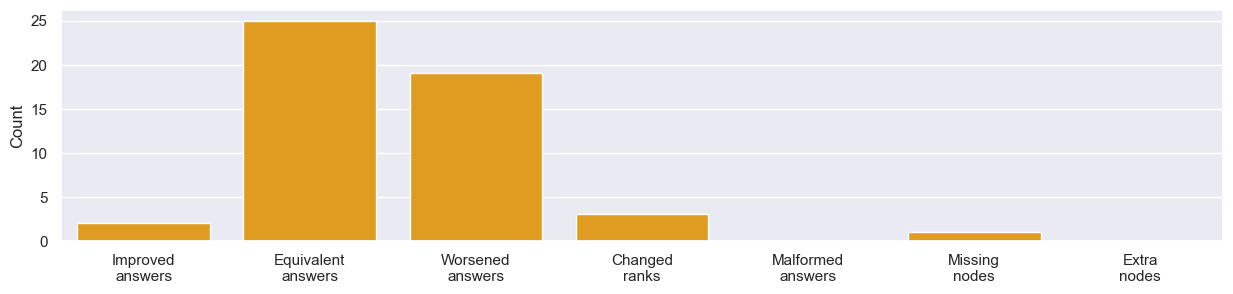

In [18]:
data_step, df_step, improved_answers_step, worsened_answers_step, equivalent_answers_step = visualize_results(results_step, color="orange")

## Results for ICL queries

In [19]:
icl_answer_dir = "answers/transpose_prompts_icl_median"
icl_answer_files = sorted(os.listdir(icl_answer_dir))
print("ICL answers:", len(icl_answer_files))

ICL answers: 50


In [20]:
icl_answers = {}
icl_answers_malformed = {}

for icl_answer_file in icl_answer_files:
    with open(os.path.join(icl_answer_dir, icl_answer_file)) as f:
        answer = f.read()

    try:
        answer_ranks = read_rank_response(answer)
        icl_answers[icl_answer_file] = answer_ranks
    except Exception as e:
        icl_answers_malformed[icl_answer_file] = answer

print("ICL answers:", len(icl_answers))
print("ICL malformed answers:", len(icl_answers_malformed))


ICL answers: 50
ICL malformed answers: 0


In [21]:
(
    correct_nodes_answers_icl,
    incorrect_nodes_answers_icl,
    increased_nodes_answers_icl,
    decreased_nodes_answers_icl,
) = check_nodes(icl_answers, queries)

correct_rank_answers_icl, incorrect_rank_answers_icl = check_ranks(correct_nodes_answers_icl, queries)

results_icl = []
for i, query in enumerate(queries):

    c = count_edge_crossings(queries[query]["edges"], queries[query]["ranks"])
    if query in correct_rank_answers_icl:
        c2 = count_edge_crossings(queries[query]["edges"], icl_answers[query])
    elif query in incorrect_rank_answers_icl:
        c2 = WRONG_RANKS
    elif query in increased_nodes_answers_icl:
        c2 = EXTRA_NODES
    elif query in decreased_nodes_answers_icl:
        c2 = MISSING_NODES
    else:
        c2 = WRONG_FORMAT
    # print("original crossings: ", c, "new crossings: ", c2)
    results_icl.append({
        "query": query,
        "original_crossings": c,
        "new_crossings": c2,
    })



Unique number of nodes in the graphs of each query:
(array([10, 11]), array([16, 34]))

Unique number of nodes in the graphs of each answer:
(array([10, 11]), array([16, 34]))

Correct nodes answers:  50
Incorrect nodes answers:  0

Increased nodes answers:  0
Decreased nodes answers:  0
Number of correct rank answers: 49
Number of incorrect rank answers: 1


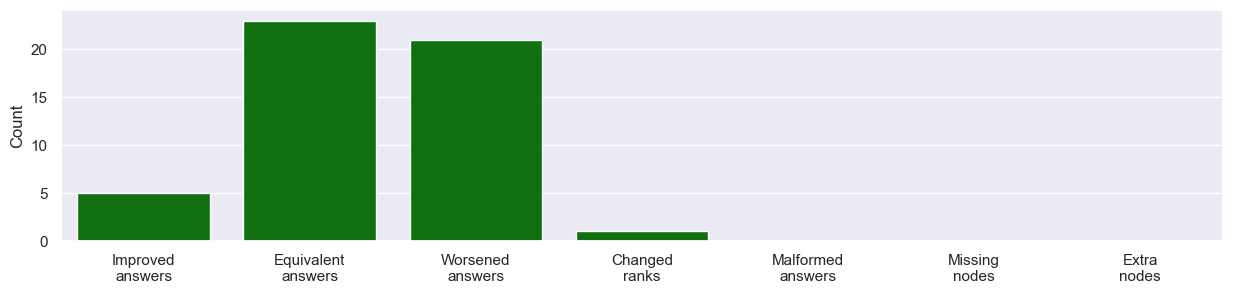

In [22]:
data_icl, df_icl, improved_answers_icl, worsened_answers_icl, equivalent_answers_icl = visualize_results(results_icl, color="green")

In [23]:
# print("Number of improved answers: ", len(improved_answers_icl))
# for k in improved_answers_icl:
#     q_edges = queries[k["query"]]["edges"]
#     q_ranks = queries[k["query"]]["ranks"]
#     r = correct_rank_answers_icl[k["query"]]
#     print("Original graph: {}".format(k["query"]))
#     print(q_ranks, q_edges)
#     visualize_graph(q_ranks, q_edges, filter_same_rank=True)
#     print("Answer graph:")
#     print(r)
#     visualize_graph(r, q_edges, filter_same_rank=True)
#     print("\n\n")

## Side by side comparison

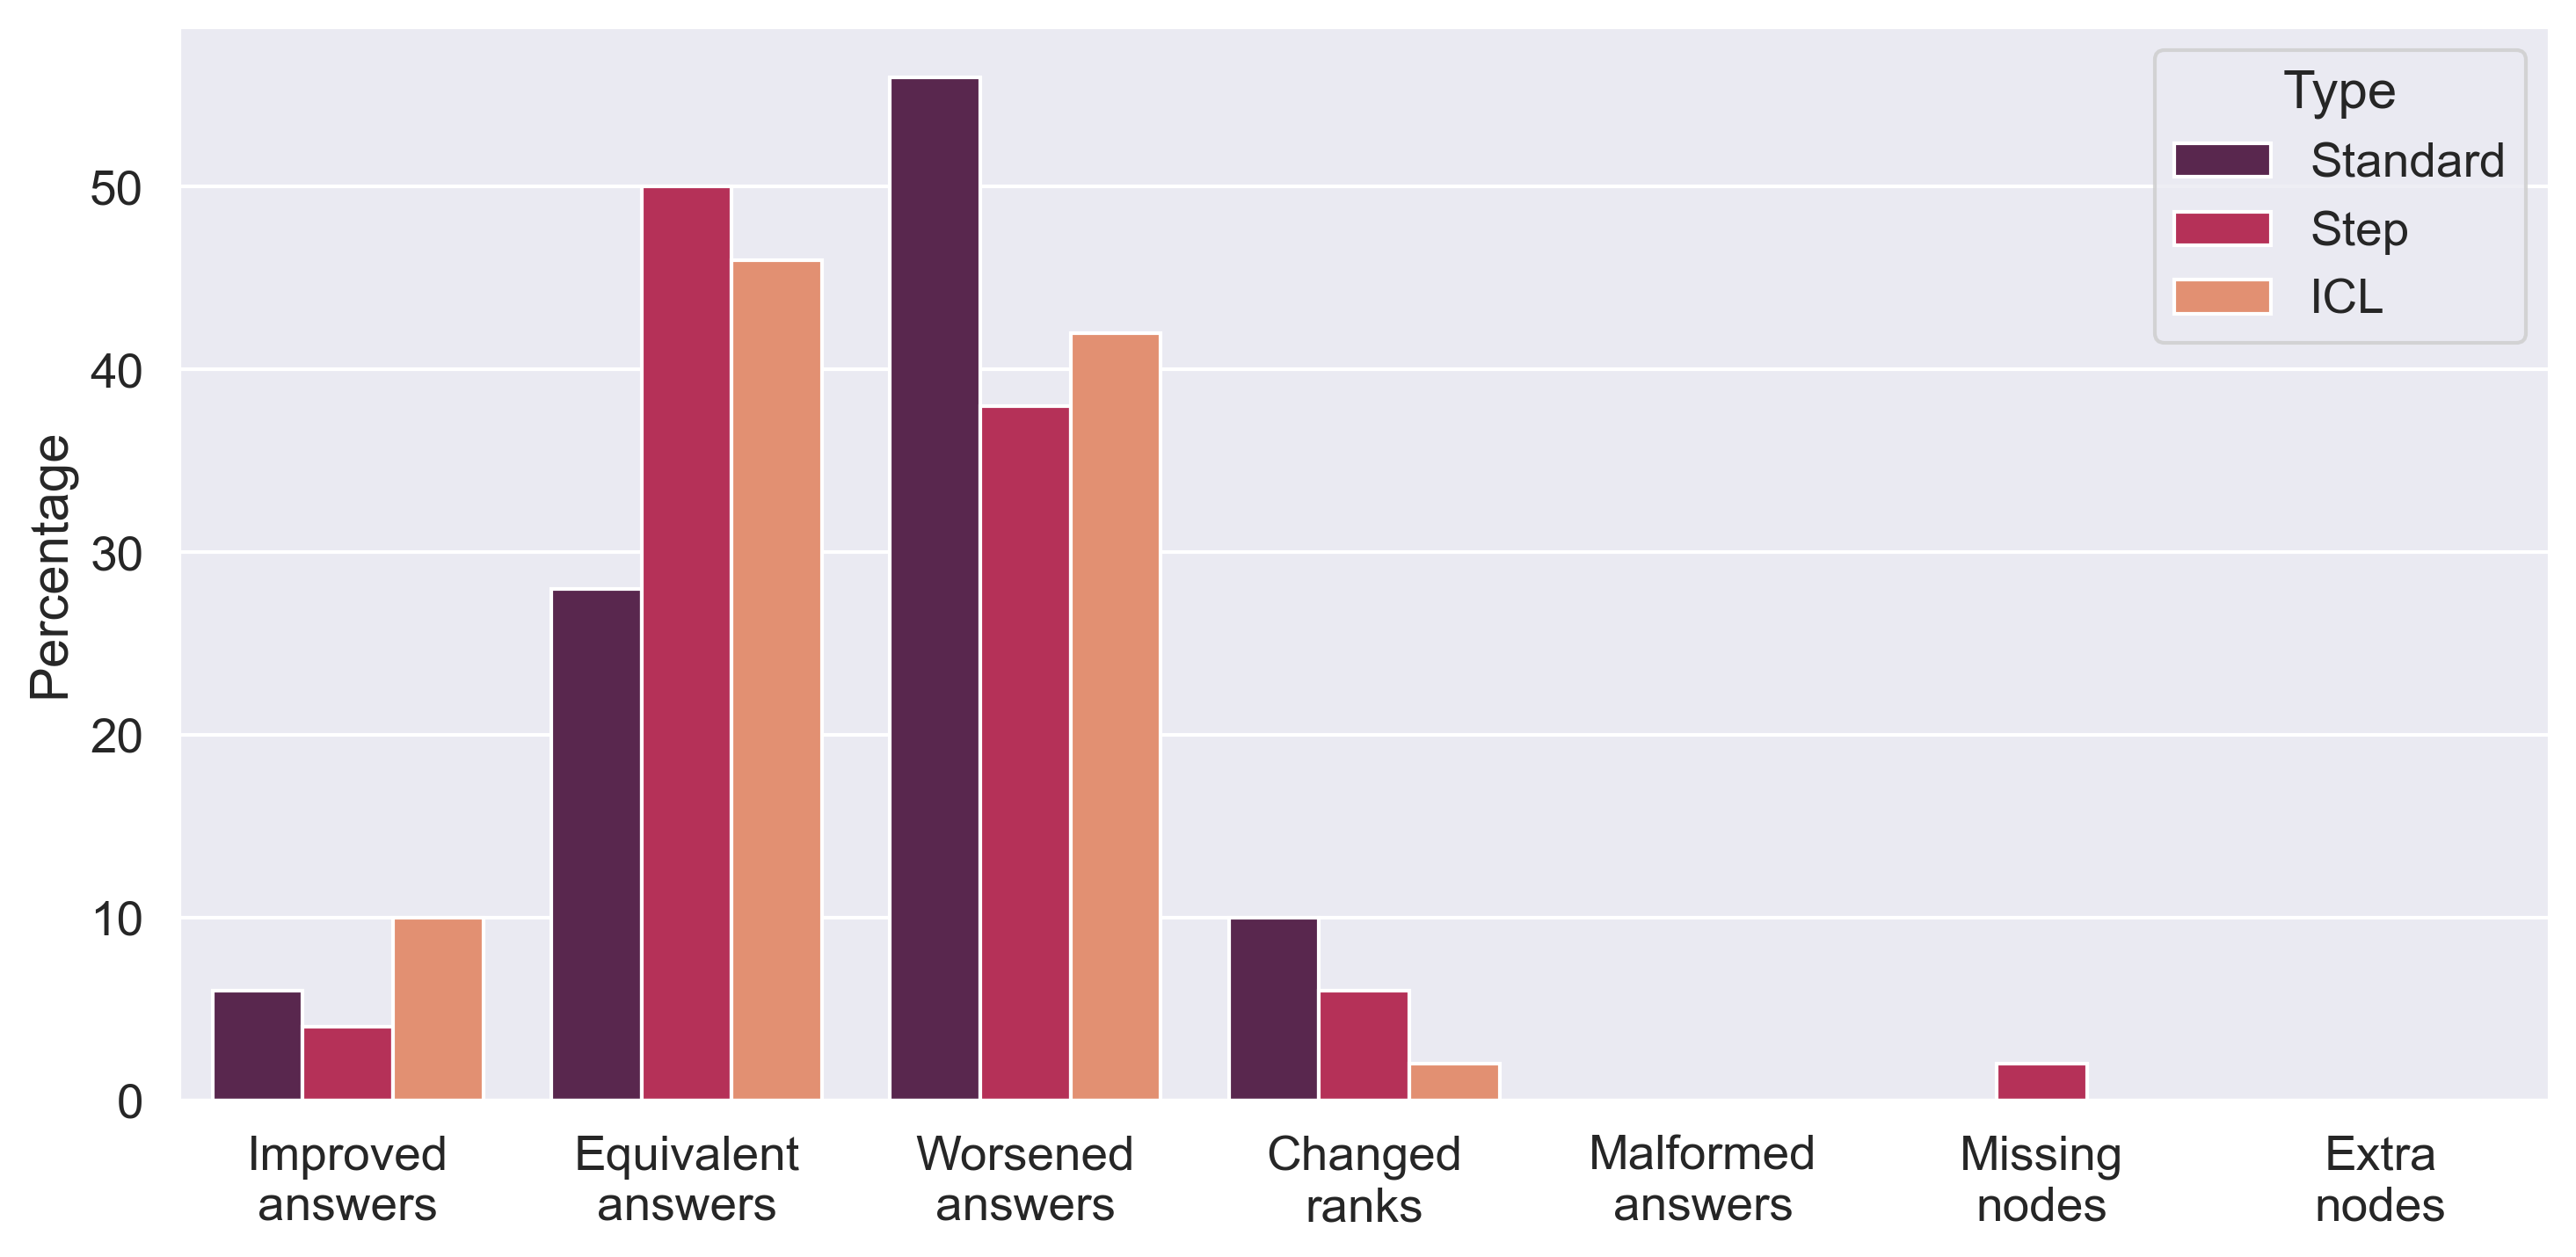

In [26]:
df_std_pt = df_std / len(queries) * 100
df_icl_pt = df_icl / len(queries) * 100
df_step_pt = df_step / len(queries) * 100

df_std_pt["Type"] = "Standard"
df_icl_pt["Type"] = "ICL"
df_step_pt["Type"] = "Step"

df_pt = pd.concat([df_std_pt, df_step_pt, df_icl_pt]).reset_index()

# sns.set(rc={'figure.figsize':(15,3)})
plt.figure(figsize=(10, 5), dpi = 300)
sns.set(font_scale=1.2)
sns.barplot(x="index", y='Value', data=df_pt, hue='Type', palette="rocket")
plt.ylabel('Percentage')
plt.xlabel(None)
plt.tight_layout()
plt.show()